# License
our code uses the MIT license. Part of our implementation is inspired by the code from [habitat_sim (MIT license)](https://aihabitat.org/), [LSeg (MIT license)](https://github.com/isl-org/lang-seg), and [CLIP (MIT license)](https://github.com/openai/CLIP). We would like to express our gratitude to the developers of these projects.

# VLMap Creation

## Download the data and install dependencies

In [1]:
root_dir = !pwd
print(root_dir)
root_dir = root_dir[0]
print(root_dir)
# !mkdir data
# %cd data
# !gdown 1wjuiVcO92Rqer5gLk-X7hINfe4PCMQmu
# !pip install tqdm
# !unzip -o 5LpN3gDmAk7_1.zip | tqdm --desc extracted --unit files --unit_scale --total `unzip -l 5LpN3gDmAk7_1.zip | tail -n 1 | xargs echo -n | cut -d' ' -f2` > /dev/null
import os
data_root = os.path.join(root_dir.split("home2")[0], "scratch/laksh.nanwani/vlmaps_data")

# checkpoint_dir = os.path.join(data_root, "checkpoints")
folder_name = "data_odom"
data_dir = os.path.join(data_root, folder_name)
# data_dir = os.path.join(data_root, "data_depth_issue")


# print(checkpoint_dir)
print(data_dir)

['/home2/laksh.nanwani/vlmaps-lab']
/home2/laksh.nanwani/vlmaps-lab
/scratch/laksh.nanwani/vlmaps_data/data_odom


## Visualize the Dataset

In [2]:
# @title Helper functions for video creation and display
import sys
import os
import imageio
import numpy as np
import cv2
import tqdm
from IPython.display import HTML
from base64 import b64encode

from scipy.spatial.transform import Rotation as R

if "google.colab" in sys.modules:
    os.environ["IMAGEIO_FFMPEG_EXE"] = "/usr/bin/ffmpeg"

# @markdown if the colab instance doesn't have GPU, untick the following checkbox
has_gpu = True # @param {type: "boolean"}
codec = "h264"
if has_gpu:
  codec = "h264_nvenc"

def load_depth(depth_filepath):
    with open(depth_filepath, 'rb') as f:
        depth = np.load(f)
    return depth / 1000
    # return depth

def load_pose(pose_filepath):
    with open(pose_filepath, 'rb') as f:
        full_pose = np.load(f)
        pos = np.array(full_pose[:3], dtype=float).reshape((3, 1))
        quat = full_pose[3:]
        # quat[[1,2]] = quat[[2,1]]
        r = R.from_quat(quat)
        rot = r.as_matrix()

        return pos, rot

def get_fast_video_writer(video_file: str, fps: int = 60):
    if (
        "google.colab" in sys.modules
        and os.path.splitext(video_file)[-1] == ".mp4"
        and os.environ.get("IMAGEIO_FFMPEG_EXE") == "/usr/bin/ffmpeg"
    ):
        # USE GPU Accelerated Hardware Encoding
        writer = imageio.get_writer(
            video_file,
            fps=fps,
            codec=codec,
            mode="I",
            bitrate="1000k",
            format="FFMPEG",
            ffmpeg_log_level="info",
            quality=10,
            output_params=["-minrate", "500k", "-maxrate", "5000k"],
        )
    else:
        # Use software encoding
        writer = imageio.get_writer(video_file, fps=fps)
    return writer

def create_video(data_dir: str, output_dir: str, fps: int = 30):
    
    rgb_dir = os.path.join(data_dir, "rgb")
    depth_dir = os.path.join(data_dir, "depth")
    rgb_out_path = os.path.join(output_dir, "rgb.mp4")
    depth_out_path = os.path.join(output_dir, "depth.mp4")
    rgb_writer = get_fast_video_writer(rgb_out_path, fps=fps)
    depth_writer = get_fast_video_writer(depth_out_path, fps=fps)

    rgb_list = sorted(os.listdir(rgb_dir), key=lambda x: int(
        x.split("_")[-1].split(".")[0]))
    depth_list = sorted(os.listdir(depth_dir), key=lambda x: int(
        x.split("_")[-1].split(".")[0]))

    rgb_list = [os.path.join(rgb_dir, x) for x in rgb_list]
    depth_list = [os.path.join(depth_dir, x) for x in depth_list]
    pbar = tqdm.tqdm(total=len(rgb_list), position=0, leave=True)
    for i, (rgb_path, depth_path) in enumerate(zip(rgb_list, depth_list)):
        bgr = cv2.imread(rgb_path)
        rgb = cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB)

        depth = load_depth(depth_path)
        depth_max = np.max(depth)
        # print(f"depth max {np.max(depth)}, depth min {np.min(depth)}")
        depth_vis = (depth / depth_max * 255).astype(np.uint8)
        # print(f"depth_vis max {np.max(depth_vis)}, depth min {np.min(depth_vis)}")

        depth_color = cv2.applyColorMap(depth_vis, cv2.COLORMAP_JET)

        rgb_writer.append_data(rgb)
        depth_writer.append_data(depth_color)
        pbar.update(1)
    rgb_writer.close()
    depth_writer.close()

def show_video(video_path, video_width = 1080):
   
    video_file = open(video_path, "r+b").read()
  
    video_url = f"data:video/mp4;base64,{b64encode(video_file).decode()}"
    return HTML(f"""<video width={video_width} autoplay controls><source src="{video_url}"></video>""")

def show_videos(video_paths, video_width = 1080):
    html = ""
    for video_path in video_paths:
        video_file = open(video_path, "r+b").read()
      
        video_url = f"data:video/mp4;base64,{b64encode(video_file).decode()}"
        html += f"""<video width={video_width} autoplay controls><source src="{video_url}"></video>
                 """
    return HTML(html)



In [3]:
# x = load_depth(os.path.join(data_dir, "depth", "depth_74.npy"))
# x[700, 500]

In [4]:
# create_video(data_dir, os.path.join(root_dir, "lab_videos"), fps=30)

In [5]:
# show rgb and depth
# show_videos([root_dir + "/rgb.mp4", root_dir + "/depth.mp4"])


## Download LSeg checkpoint

In [6]:
# %cd {data_root}
# !mkdir lseg
# %cd lseg
# !mkdir checkpoints
# %cd checkpoints
# !gdown 1ayk6NXURI_vIPlym16f_RG3ffxBWHxvb
# !ls
# %cd {root_dir}

## VLMap Creation
It takes around 20 minutes to build a VLMap with around 1000 RGBD frames. We also provide a pre-built VLMap. Skip to the Landmark Indexing part of the code to directly try our map.

In [7]:
# setup parameters
# @markdown meters per cell size
cs = 0.05 # @param {type: "number"}
# @markdown map resolution (gs x gs)
gs = 1000 # @param {type: "integer"}
# @markdown camera height (used for filtering out points on the floor)
# camera_height = 1.5 # @param {type: "number"}
# 0.747 - odom -> camera_link
# 0.51 - map -> camera_link
# camera_height = 0.747
camera_translation = [0.2, -0.222, 0.512]
# @markdown depth pixels subsample rate
depth_sample_rate = 50 # @param {type: "integer"}
# @markdown data where rgb, depth, pose are loaded and map are saved
data_dir = data_dir # @param {type: "string"}

In [8]:
# x = np.arange(6).reshape((2,3))
# (x[1, :] > 2) & (x[1, :] < 4)

In [9]:
# @title Helper functions for VLMap Creation

import os
import math

import numpy as np
import cv2
from tqdm import tqdm
import torch
import torchvision.transforms as transforms
import clip
import matplotlib.pyplot as plt

from utils.clip_mapping_utils import load_semantic, load_obj2cls_dict, save_map, cvt_obj_id_2_cls_id, depth2pc_realsense, transform_pc, get_real_cam_mat, pos2grid_id, project_point, get_color
# from utils.clip_mapping_utils import load_pose

from lseg.modules.models.lseg_net import LSegEncNet
from lseg.additional_utils.models import resize_image, pad_image, crop_image

def create_lseg_map_batch(img_save_dir, camera_translation, cs=0.05, gs=1000, depth_sample_rate=100):
    mask_version = 1 # 0, 1

    crop_size = 480 # 480
    base_size = 520 # 520
    lang = "door,chair,ground,ceiling,window,other"
    labels = lang.split(",")

    # loading models
    device = "cuda:1" if torch.cuda.is_available() else "cpu"
    print(device)
    clip_version = "ViT-B/32"
    clip_feat_dim = {'RN50': 1024, 'RN101': 512, 'RN50x4': 640, 'RN50x16': 768,
                    'RN50x64': 1024, 'ViT-B/32': 512, 'ViT-B/16': 512, 'ViT-L/14': 768}[clip_version]
    print("Loading CLIP model...")
    clip_model, preprocess = clip.load(clip_version, device = device)  # clip.available_models()
    clip_model.to(device).eval()
    # print("Clip model -", clip_model.is_cuda())
    # x = torch.randn((5,5)).to(device=device)
    # print("Tensor device - ", type(x))
    # clip_model.eval()
    lang_token = clip.tokenize(labels)
    lang_token = lang_token.to(device)
    with torch.no_grad():
        text_feats = clip_model.encode_text(lang_token)
        text_feats = text_feats / text_feats.norm(dim=-1, keepdim=True)
    text_feats = text_feats.cpu().numpy()
    model = LSegEncNet(lang, arch_option=0,
                        block_depth=0,
                        activation='lrelu',
                        crop_size=crop_size)
    model_state_dict = model.state_dict()
    global data_root
    checkpoint_path = os.path.join(data_root, "lseg/checkpoints/demo_e200.ckpt")

    print("Loading lseg checkpoint")
    pretrained_state_dict = torch.load(checkpoint_path, map_location = device)
    print("Lseg loaded")
    pretrained_state_dict = {k.lstrip('net.'): v for k, v in pretrained_state_dict['state_dict'].items()}
    model_state_dict.update(pretrained_state_dict)
    model.load_state_dict(pretrained_state_dict)

    model.eval()
    model = model.cuda()

    norm_mean= [0.5, 0.5, 0.5]
    norm_std = [0.5, 0.5, 0.5]
    padding = [0.0] * 3
    transform = transforms.Compose(
        [
            transforms.ToTensor(),
            transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5]),
        ]
    )

    print(f"loading scene {img_save_dir}")
    rgb_dir = os.path.join(img_save_dir, "rgb")
    depth_dir = os.path.join(img_save_dir, "depth")
    pose_dir = os.path.join(img_save_dir, "pose")
    # semantic_dir = os.path.join(img_save_dir, "semantic")
    # obj2cls_path = os.path.join(img_save_dir, "obj2cls_dict.txt")

    rgb_list = sorted(os.listdir(rgb_dir), key=lambda x: int(
        x.split("_")[-1].split(".")[0]))
    depth_list = sorted(os.listdir(depth_dir), key=lambda x: int(
        x.split("_")[-1].split(".")[0]))
    pose_list = sorted(os.listdir(pose_dir), key=lambda x: int(
        x.split("_")[-1].split(".")[0]))
    # pose_list = sorted(os.listdir(pose_dir), key=lambda x: int(
    #     x.split("_")[-1].split(".")[0]))
    # semantic_list = sorted(os.listdir(semantic_dir), key=lambda x: int(
    #     x.split("_")[-1].split(".")[0]))

    rgb_list = [os.path.join(rgb_dir, x) for x in rgb_list]
    depth_list = [os.path.join(depth_dir, x) for x in depth_list]
    pose_list = [os.path.join(pose_dir, x) for x in pose_list]
    # semantic_list = [os.path.join(semantic_dir, x) for x in semantic_list]


    map_save_dir = os.path.join(img_save_dir, "map")
    os.makedirs(map_save_dir, exist_ok=True)
    color_top_down_save_path = os.path.join(map_save_dir, f"color_top_down_{mask_version}.npy")
    # gt_save_path = os.path.join(map_save_dir, f"grid_{mask_version}_gt.npy")
    grid_save_path = os.path.join(map_save_dir, f"grid_lseg_{mask_version}.npy")
    weight_save_path = os.path.join(map_save_dir, f"weight_lseg_{mask_version}.npy")
    obstacles_save_path = os.path.join(map_save_dir, "obstacles.npy")

    # obj2cls = load_obj2cls_dict(obj2cls_path)

    # initialize a grid with zero position at the center
    color_top_down_height = (camera_translation[2] + 1) * np.ones((gs, gs), dtype=np.float32)
    color_top_down = np.zeros((gs, gs, 3), dtype=np.uint8)
    # gt = np.zeros((gs, gs), dtype=np.int32)
    grid = np.zeros((gs, gs, clip_feat_dim), dtype=np.float32)
    obstacles = np.ones((gs, gs), dtype=np.uint8)
    weight = np.zeros((gs, gs), dtype=float)

    # save_map(color_top_down_save_path, color_top_down)
    # # save_map(gt_save_path, gt)
    # save_map(grid_save_path, grid)
    # save_map(weight_save_path, weight)
    # save_map(obstacles_save_path, obstacles)

    tf_list = []
    # data_iter = zip(rgb_list, depth_list, semantic_list, pose_list)
    data_iter = zip(rgb_list, depth_list, pose_list)
    pbar = tqdm(total=len(rgb_list))
    # load all images and depths and poses
    # print('here')
    count = 0

    trans_cam = np.zeros((4,4))
    trans_cam[0, 2] = 1
    trans_cam[1, 0] = -1
    trans_cam[2, 1] = -1

    trans_cam[:3,3] = np.array(camera_translation)
    trans_cam[3,3] = 1

    pc_combined = []
    colors = []
    feature_cloud = []
    
    for data_sample in data_iter:
        count += 1
        # if count % 15 != 0:
        #     continue

        feature_list = []
        pixel_coords = []
        # count += 1
        # if count % 3 != 0:
        #     continue
        # rgb_path, depth_path, semantic_path, pose_path = data_sample
        rgb_path, depth_path, pose_path = data_sample

        
        bgr = cv2.imread(rgb_path)
        rgb = cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB)
        out = rgb.copy()

        # read pose
        # pos, rot = load_pose(pose_path)  # z backward, y upward, x to the right -> theirs
        pos, rot = load_pose(pose_path)  # x front, y left, z upward -> ours

        pose = np.eye(4)
        pose[:3, :3] = rot
        pose[:3, 3] = pos.reshape(-1)

        # pose = pose @ trans_cam

        tf_list.append(pose)
        if len(tf_list) == 1:
            init_tf_inv = np.linalg.inv(tf_list[0])

        tf = init_tf_inv @ pose @ trans_cam

        # read depth
        depth = load_depth(depth_path)
        # print(f"depth shape = {depth.shape}")
        # break
        # read semantic
        # semantic = load_semantic(semantic_path)
        # semantic = cvt_obj_id_2_cls_id(semantic, obj2cls)

        pix_feats = get_lseg_feat(model, rgb, labels, transform, crop_size, base_size, norm_mean, norm_std)
        # print(pix_feats.shape)
        # transform all points to the global frame
        pc, mask = depth2pc_realsense(depth)
        shuffle_mask = np.arange(pc.shape[1]) 
        np.random.shuffle(shuffle_mask)
        shuffle_mask = shuffle_mask[::depth_sample_rate]
        mask = mask[shuffle_mask]
        pc = pc[:, shuffle_mask]
        pc = pc[:, mask]
        pc_global = transform_pc(pc, tf)

        original_dims = (rgb.shape[1], rgb.shape[0])
        rgb_cam_mat = get_real_cam_mat(original_dims, original_dims)
        # print(rgb_cam_mat)
        feat_cam_mat = get_real_cam_mat(original_dims, (pix_feats.shape[3], pix_feats.shape[2]))
        # print(feat_cam_mat)

        color_local = get_color(rgb)
        color_local = color_local[:, shuffle_mask]
        color_local = color_local[:, mask]

        if len(pc_combined) == 0:
            pc_combined = pc_global
            colors = color_local
        else:
            pc_combined = np.hstack((pc_combined, pc_global))
            # print(color_local.shape, colors.shape)
            colors = np.hstack((colors, color_local))
        # print(f"pc_local shape {pc.shape}")
        # project all point cloud onto the ground
        for i, (p, p_local) in enumerate(zip(pc_global.T, pc.T)):
            x, y = pos2grid_id(gs, cs, p[0], p[1])   # changed p[2] -> p[1], i.e, z -> y

            # ignore points projected to outside of the map and points that are 0.5 higher than the camera (could be from the ceiling)
            if x >= obstacles.shape[0] or y >= obstacles.shape[1] or \
                x < 0 or y < 0 or p_local[1] < -1.0:
                continue

            rgb_px, rgb_py, rgb_pz = project_point(rgb_cam_mat, p_local)
            rgb_v = rgb[rgb_py, rgb_px, :]
            # semantic_v = semantic[rgb_py, rgb_px]
            # if semantic_v == 40:
            #     semantic_v = -1
            
            # when the projected location is already assigned a color value before, overwrite if the current point has larger height
            if p_local[1] < color_top_down_height[y, x]:
                color_top_down[y, x] = rgb_v
                color_top_down_height[y, x] = p_local[1]
                # gt[y, x] = semantic_v

            # average the visual embeddings if multiple points are projected to the same grid cell
            px, py, pz = project_point(feat_cam_mat, p_local)
            if not (px < 0 or py < 0 or px >= pix_feats.shape[3] or py >= pix_feats.shape[2]):
                feat = pix_feats[0, :, py, px]
                # print(feat.shape)
                # feature_cloud.append(feat)
                grid[y, x] = (grid[y, x] * weight[y, x] + feat) / (weight[y, x] + 1)
                # print(grid[y, x].shape)
                weight[y, x] += 1
                
                # if count == 1:
                #     pixel_coords.append([rgb_py, rgb_px])
                #     feature_list.append(feat)
                #     out = cv2.circle(out, (rgb_px, rgb_py), radius = 2, color = (255, 0, 0), thickness = 1)
            
            # build an obstacle map ignoring points on the floor (0 means occupied, 1 means free)
            if p_local[1] > camera_translation[2]:
                continue
            obstacles[y, x] = 0

        # plt.imshow(out)
        # plt.show()
        pbar.update(1)
        # count += 1
        break
        # if count == 75:
            # break
        # print(len(pixel_coords))
        # print(feature_list.shape)

    pixel_coords = np.array(pixel_coords)
    feature_list = np.array(feature_list)   
    # save_map(color_top_down_save_path, color_top_down)
    # save_map(gt_save_path, gt)
    # save_map(grid_save_path, grid)
    # save_map(weight_save_path, weight)
    # save_map(obstacles_save_path, obstacles)
    np.save(os.path.join(map_save_dir, "pixel_coords.npy"), pixel_coords)
    np.save(os.path.join(map_save_dir, "features_list.npy"), feature_list)
    # print(pixel_coords.shape)
    # print(feature_list.shape)
    # np.save(os.path.join(map_save_dir, "pointcloud.npy"), pc_combined)
    # np.save(os.path.join(map_save_dir, "colors.npy"), colors)


def get_lseg_feat(model: LSegEncNet, image: np.array, labels, transform, crop_size=480, \
                 base_size=520, norm_mean=[0.5, 0.5, 0.5], norm_std=[0.5, 0.5, 0.5]):
    vis_image = image.copy()
    image = transform(image).unsqueeze(0).cuda()
    # img = image[0].permute(1,2,0)
    # img = img * 0.5 + 0.5
    
    batch, _, h, w = image.size()
    stride_rate = 2.0/3.0
    stride = int(crop_size * stride_rate)

    long_size = base_size
    if h > w:
        height = long_size
        width = int(1.0 * w * long_size / h + 0.5)
        short_size = width
    else:
        width = long_size
        height = int(1.0 * h * long_size / w + 0.5)
        short_size = height


    cur_img = resize_image(image, height, width, **{'mode': 'bilinear', 'align_corners': True})

    if long_size <= crop_size:
        pad_img = pad_image(cur_img, norm_mean,
                            norm_std, crop_size)
        # print(pad_img.shape)
        with torch.no_grad():
            outputs, logits = model(pad_img, labels)

        # print(f"1 {outputs.shape}")
        outputs = crop_image(outputs, 0, height, 0, width)
    else:
        if short_size < crop_size:
            # pad if needed
            pad_img = pad_image(cur_img, norm_mean,
                                norm_std, crop_size)
        else:
            pad_img = cur_img

        _,_,ph,pw = pad_img.shape #.size()
        assert(ph >= height and pw >= width)
        h_grids = int(math.ceil(1.0 * (ph-crop_size)/stride)) + 1
        w_grids = int(math.ceil(1.0 * (pw-crop_size)/stride)) + 1
        with torch.cuda.device_of(image):
            with torch.no_grad():
                outputs = image.new().resize_(batch, model.out_c,ph,pw).zero_().cuda()
                logits_outputs = image.new().resize_(batch, len(labels),ph,pw).zero_().cuda()
            count_norm = image.new().resize_(batch,1,ph,pw).zero_().cuda()
        # grid evaluation
        for idh in range(h_grids):
            for idw in range(w_grids):
                h0 = idh * stride
                w0 = idw * stride
                h1 = min(h0 + crop_size, ph)
                w1 = min(w0 + crop_size, pw)
                crop_img = crop_image(pad_img, h0, h1, w0, w1)
                # pad if needed
                pad_crop_img = pad_image(crop_img, norm_mean,
                                            norm_std, crop_size)

                # print(f"3 {pad_crop_img.shape}")
                with torch.no_grad():
                    output, logits = model(pad_crop_img, labels)

                # print(f"2 {outputs.shape}")
                cropped = crop_image(output, 0, h1-h0, 0, w1-w0)
                cropped_logits = crop_image(logits, 0, h1-h0, 0, w1-w0)
                outputs[:,:,h0:h1,w0:w1] += cropped
                logits_outputs[:,:,h0:h1,w0:w1] += cropped_logits
                count_norm[:,:,h0:h1,w0:w1] += 1
        assert((count_norm==0).sum()==0)
        outputs = outputs / count_norm
        logits_outputs = logits_outputs / count_norm
        outputs = outputs[:,:,:height,:width]
        logits_outputs = logits_outputs[:,:,:height,:width]
    outputs = outputs.cpu()
    outputs = outputs.numpy() # B, D, H, W
    predicts = [torch.max(logit, 0)[1].cpu().numpy() for logit in logits_outputs]
    pred = predicts[0]
    # print(pad_img.shape)
    # print(outputs.shape)
    return outputs

__file__:  /home2/laksh.nanwani/vlmaps-lab/examples/context.py
imported path: /home2/laksh.nanwani/vlmaps-lab


In [10]:
def cosine_similarity(a,b):
    cos_sim = np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b))
    return cos_sim

In [11]:
create_lseg_map_batch(data_dir, camera_translation=camera_translation, cs=cs, gs=gs, depth_sample_rate=depth_sample_rate)

cuda:1
Loading CLIP model...
Loading lseg checkpoint
Lseg loaded
loading scene /scratch/laksh.nanwani/vlmaps_data/data_odom


  0%|          | 0/274 [00:00<?, ?it/s]

pc_local shape (3, 9489)


  0%|          | 1/274 [00:02<12:32,  2.76s/it]

pc_local shape (3, 9581)


  1%|          | 2/274 [00:04<09:12,  2.03s/it]

pc_local shape (3, 9394)


  1%|          | 3/274 [00:06<09:49,  2.18s/it]

pc_local shape (3, 9527)


  1%|▏         | 4/274 [00:07<08:14,  1.83s/it]

pc_local shape (3, 9542)


  2%|▏         | 5/274 [00:09<07:18,  1.63s/it]

pc_local shape (3, 9706)


  2%|▏         | 6/274 [00:11<08:53,  1.99s/it]

pc_local shape (3, 9664)


  3%|▎         | 7/274 [00:13<08:14,  1.85s/it]

pc_local shape (3, 9943)


  3%|▎         | 8/274 [00:15<08:04,  1.82s/it]

pc_local shape (3, 9933)


  3%|▎         | 9/274 [00:17<08:57,  2.03s/it]

pc_local shape (3, 10093)


  4%|▎         | 10/274 [00:20<09:25,  2.14s/it]

pc_local shape (3, 10309)


  4%|▍         | 11/274 [00:22<09:13,  2.10s/it]

pc_local shape (3, 10569)


  4%|▍         | 12/274 [00:23<08:21,  1.91s/it]

pc_local shape (3, 10413)


  5%|▍         | 13/274 [00:26<09:38,  2.21s/it]

pc_local shape (3, 10522)


  5%|▌         | 14/274 [00:27<08:39,  2.00s/it]

pc_local shape (3, 10394)


  5%|▌         | 15/274 [00:30<09:22,  2.17s/it]

pc_local shape (3, 10386)


  6%|▌         | 16/274 [00:31<08:17,  1.93s/it]

pc_local shape (3, 10528)


  6%|▌         | 17/274 [00:33<07:38,  1.78s/it]

pc_local shape (3, 10421)


  7%|▋         | 18/274 [00:35<08:25,  1.97s/it]

pc_local shape (3, 10366)


  7%|▋         | 19/274 [00:37<07:36,  1.79s/it]

pc_local shape (3, 10348)


  7%|▋         | 20/274 [00:38<07:22,  1.74s/it]

pc_local shape (3, 10243)


  8%|▊         | 21/274 [00:40<07:09,  1.70s/it]

pc_local shape (3, 10315)


  8%|▊         | 22/274 [00:41<06:47,  1.62s/it]

pc_local shape (3, 10343)


  8%|▊         | 23/274 [00:44<08:29,  2.03s/it]

pc_local shape (3, 10346)


  9%|▉         | 24/274 [00:46<07:48,  1.87s/it]

pc_local shape (3, 10292)


  9%|▉         | 25/274 [00:47<07:30,  1.81s/it]

pc_local shape (3, 10474)


  9%|▉         | 26/274 [00:50<08:02,  1.94s/it]

pc_local shape (3, 10345)


 10%|▉         | 27/274 [00:52<08:37,  2.10s/it]

pc_local shape (3, 10593)


 10%|█         | 28/274 [00:54<07:51,  1.92s/it]

pc_local shape (3, 10527)


 11%|█         | 29/274 [00:55<07:34,  1.86s/it]

pc_local shape (3, 10401)


 11%|█         | 30/274 [00:58<08:27,  2.08s/it]

pc_local shape (3, 10241)


 11%|█▏        | 31/274 [01:00<07:57,  1.96s/it]

pc_local shape (3, 10233)


 12%|█▏        | 32/274 [01:01<07:43,  1.92s/it]

pc_local shape (3, 10278)


 12%|█▏        | 33/274 [01:04<08:48,  2.19s/it]

pc_local shape (3, 10274)


 12%|█▏        | 34/274 [01:06<07:46,  1.94s/it]

pc_local shape (3, 9997)


 13%|█▎        | 35/274 [01:08<08:30,  2.14s/it]

pc_local shape (3, 9774)


 13%|█▎        | 36/274 [01:10<07:45,  1.96s/it]

pc_local shape (3, 9555)


 14%|█▎        | 37/274 [01:11<07:16,  1.84s/it]

pc_local shape (3, 9608)


 14%|█▍        | 38/274 [01:14<08:01,  2.04s/it]

pc_local shape (3, 9798)


 14%|█▍        | 39/274 [01:17<08:52,  2.26s/it]

pc_local shape (3, 10183)


 15%|█▍        | 40/274 [01:18<07:50,  2.01s/it]

pc_local shape (3, 10544)


 15%|█▍        | 41/274 [01:20<07:33,  1.95s/it]

pc_local shape (3, 10538)


 15%|█▌        | 42/274 [01:22<07:54,  2.05s/it]

pc_local shape (3, 10583)


 16%|█▌        | 43/274 [01:24<07:39,  1.99s/it]

pc_local shape (3, 10490)


 16%|█▌        | 44/274 [01:25<06:46,  1.77s/it]

pc_local shape (3, 10404)


 16%|█▋        | 45/274 [01:28<07:29,  1.96s/it]

pc_local shape (3, 10368)


 17%|█▋        | 46/274 [01:29<06:54,  1.82s/it]

pc_local shape (3, 10529)


 17%|█▋        | 47/274 [01:31<06:46,  1.79s/it]

pc_local shape (3, 10186)


 18%|█▊        | 48/274 [01:33<07:34,  2.01s/it]

pc_local shape (3, 10238)


 18%|█▊        | 49/274 [01:35<06:41,  1.78s/it]

pc_local shape (3, 10074)


 18%|█▊        | 50/274 [01:36<06:27,  1.73s/it]

pc_local shape (3, 10011)


 19%|█▊        | 51/274 [01:39<07:12,  1.94s/it]

pc_local shape (3, 9754)


 19%|█▉        | 52/274 [01:41<07:33,  2.04s/it]

pc_local shape (3, 9897)


 19%|█▉        | 53/274 [01:43<07:47,  2.12s/it]

pc_local shape (3, 10135)


 20%|█▉        | 54/274 [01:46<08:25,  2.30s/it]

pc_local shape (3, 10177)


 20%|██        | 55/274 [01:48<07:37,  2.09s/it]

pc_local shape (3, 10150)


 20%|██        | 56/274 [01:50<08:07,  2.23s/it]

pc_local shape (3, 10210)


 21%|██        | 57/274 [01:52<07:36,  2.11s/it]

pc_local shape (3, 10283)


 21%|██        | 58/274 [01:54<07:14,  2.01s/it]

pc_local shape (3, 10208)


 22%|██▏       | 59/274 [01:56<07:44,  2.16s/it]

pc_local shape (3, 10016)


 22%|██▏       | 60/274 [01:59<08:30,  2.39s/it]

pc_local shape (3, 9978)


 22%|██▏       | 61/274 [02:01<07:26,  2.10s/it]

pc_local shape (3, 9854)


 23%|██▎       | 62/274 [02:02<06:57,  1.97s/it]

pc_local shape (3, 9496)


 23%|██▎       | 63/274 [02:05<07:15,  2.06s/it]

pc_local shape (3, 9772)


 23%|██▎       | 64/274 [02:06<06:57,  1.99s/it]

pc_local shape (3, 9982)


 24%|██▎       | 65/274 [02:09<07:33,  2.17s/it]

pc_local shape (3, 10145)


 24%|██▍       | 66/274 [02:12<08:17,  2.39s/it]

pc_local shape (3, 10802)


 24%|██▍       | 67/274 [02:13<07:24,  2.15s/it]

pc_local shape (3, 12266)


 25%|██▍       | 68/274 [02:16<07:52,  2.29s/it]

pc_local shape (3, 13218)


 25%|██▌       | 69/274 [02:18<07:23,  2.17s/it]

pc_local shape (3, 14410)


 26%|██▌       | 70/274 [02:20<07:06,  2.09s/it]

pc_local shape (3, 15596)


 26%|██▌       | 71/274 [02:23<08:19,  2.46s/it]

pc_local shape (3, 16579)


 26%|██▋       | 72/274 [02:25<07:34,  2.25s/it]

pc_local shape (3, 16601)


 27%|██▋       | 73/274 [02:27<07:42,  2.30s/it]

pc_local shape (3, 16470)


 27%|██▋       | 74/274 [02:30<08:17,  2.49s/it]

pc_local shape (3, 16190)


 27%|██▋       | 75/274 [02:32<07:33,  2.28s/it]

pc_local shape (3, 15795)


 28%|██▊       | 76/274 [02:36<08:37,  2.62s/it]

pc_local shape (3, 15271)


 28%|██▊       | 77/274 [02:37<07:33,  2.30s/it]

pc_local shape (3, 14824)


 28%|██▊       | 78/274 [02:39<07:02,  2.16s/it]

pc_local shape (3, 16222)


 29%|██▉       | 79/274 [02:42<07:32,  2.32s/it]

pc_local shape (3, 17167)


 29%|██▉       | 80/274 [02:44<07:17,  2.26s/it]

pc_local shape (3, 17097)


 30%|██▉       | 81/274 [02:47<08:21,  2.60s/it]

pc_local shape (3, 17043)


 30%|██▉       | 82/274 [02:49<07:27,  2.33s/it]

pc_local shape (3, 17114)


 30%|███       | 83/274 [02:51<07:21,  2.31s/it]

pc_local shape (3, 16393)


 31%|███       | 84/274 [02:53<06:34,  2.08s/it]

pc_local shape (3, 14771)


 31%|███       | 85/274 [02:54<06:20,  2.01s/it]

pc_local shape (3, 11285)


 31%|███▏      | 86/274 [02:57<06:46,  2.16s/it]

pc_local shape (3, 10374)


 32%|███▏      | 87/274 [02:59<06:19,  2.03s/it]

pc_local shape (3, 10149)


 32%|███▏      | 88/274 [03:00<06:00,  1.94s/it]

pc_local shape (3, 9813)


 32%|███▏      | 89/274 [03:02<05:32,  1.80s/it]

pc_local shape (3, 9823)


 33%|███▎      | 90/274 [03:05<06:30,  2.12s/it]

pc_local shape (3, 11397)


 33%|███▎      | 91/274 [03:06<05:52,  1.93s/it]

pc_local shape (3, 14480)


 34%|███▎      | 92/274 [03:08<05:50,  1.93s/it]

pc_local shape (3, 16751)


 34%|███▍      | 93/274 [03:12<07:10,  2.38s/it]

pc_local shape (3, 16798)


 34%|███▍      | 94/274 [03:18<10:50,  3.61s/it]

pc_local shape (3, 16754)


 35%|███▍      | 95/274 [03:22<11:23,  3.82s/it]

pc_local shape (3, 17310)


 35%|███▌      | 96/274 [03:30<14:25,  4.86s/it]

pc_local shape (3, 16994)


 35%|███▌      | 97/274 [03:34<14:13,  4.82s/it]

pc_local shape (3, 16786)


 36%|███▌      | 98/274 [03:37<11:58,  4.08s/it]

pc_local shape (3, 16653)


 36%|███▌      | 99/274 [03:40<10:43,  3.68s/it]

pc_local shape (3, 15459)


 36%|███▋      | 100/274 [03:42<09:21,  3.23s/it]

pc_local shape (3, 9933)


 37%|███▋      | 101/274 [03:43<07:49,  2.71s/it]

pc_local shape (3, 9711)


 37%|███▋      | 102/274 [03:45<07:03,  2.46s/it]

pc_local shape (3, 9890)


 38%|███▊      | 103/274 [03:48<07:09,  2.51s/it]

pc_local shape (3, 9698)


 38%|███▊      | 104/274 [03:49<06:09,  2.18s/it]

pc_local shape (3, 9752)


 38%|███▊      | 105/274 [03:51<05:48,  2.06s/it]

pc_local shape (3, 9864)


 39%|███▊      | 106/274 [03:53<05:23,  1.92s/it]

pc_local shape (3, 10006)


 39%|███▉      | 107/274 [03:54<05:20,  1.92s/it]

pc_local shape (3, 10105)


 39%|███▉      | 108/274 [03:57<05:46,  2.09s/it]

pc_local shape (3, 10063)


 40%|███▉      | 109/274 [03:59<05:21,  1.95s/it]

pc_local shape (3, 10346)


 40%|████      | 110/274 [04:01<06:05,  2.23s/it]

pc_local shape (3, 10011)


 41%|████      | 111/274 [04:04<06:10,  2.27s/it]

pc_local shape (3, 10315)


 41%|████      | 112/274 [04:06<06:02,  2.24s/it]

pc_local shape (3, 10067)


 41%|████      | 113/274 [04:07<05:23,  2.01s/it]

pc_local shape (3, 9972)


 42%|████▏     | 114/274 [04:10<06:04,  2.28s/it]

pc_local shape (3, 9863)


 42%|████▏     | 115/274 [04:12<05:18,  2.01s/it]

pc_local shape (3, 9864)


 42%|████▏     | 116/274 [04:14<05:36,  2.13s/it]

pc_local shape (3, 9743)


 43%|████▎     | 117/274 [04:16<05:00,  1.92s/it]

pc_local shape (3, 9944)


 43%|████▎     | 118/274 [04:17<04:41,  1.81s/it]

pc_local shape (3, 9982)


 43%|████▎     | 119/274 [04:20<05:13,  2.02s/it]

pc_local shape (3, 9897)


 44%|████▍     | 120/274 [04:21<04:41,  1.83s/it]

pc_local shape (3, 9713)


 44%|████▍     | 121/274 [04:24<05:37,  2.21s/it]

pc_local shape (3, 9662)


 45%|████▍     | 122/274 [04:26<05:02,  1.99s/it]

pc_local shape (3, 9664)


 45%|████▍     | 123/274 [04:27<04:53,  1.94s/it]

pc_local shape (3, 9750)


 45%|████▌     | 124/274 [04:29<04:40,  1.87s/it]

pc_local shape (3, 9864)


 46%|████▌     | 125/274 [04:31<04:26,  1.79s/it]

pc_local shape (3, 9955)


 46%|████▌     | 126/274 [04:33<04:48,  1.95s/it]

pc_local shape (3, 9808)


 46%|████▋     | 127/274 [04:34<04:21,  1.78s/it]

pc_local shape (3, 9896)


 47%|████▋     | 128/274 [04:37<05:12,  2.14s/it]

pc_local shape (3, 9659)


 47%|████▋     | 129/274 [04:39<04:42,  1.95s/it]

pc_local shape (3, 9816)


 47%|████▋     | 130/274 [04:40<04:21,  1.82s/it]

pc_local shape (3, 9829)


 48%|████▊     | 131/274 [04:43<04:51,  2.04s/it]

pc_local shape (3, 9802)


 48%|████▊     | 132/274 [04:46<05:11,  2.19s/it]

pc_local shape (3, 9580)


 49%|████▊     | 133/274 [04:47<04:33,  1.94s/it]

pc_local shape (3, 9154)


 49%|████▉     | 134/274 [04:49<04:26,  1.91s/it]

pc_local shape (3, 9012)


 49%|████▉     | 135/274 [04:50<04:11,  1.81s/it]

pc_local shape (3, 8684)


 50%|████▉     | 136/274 [04:52<03:58,  1.73s/it]

pc_local shape (3, 8615)


 50%|█████     | 137/274 [04:55<04:37,  2.03s/it]

pc_local shape (3, 8521)


 50%|█████     | 138/274 [04:56<04:02,  1.78s/it]

pc_local shape (3, 8523)


 51%|█████     | 139/274 [04:57<03:48,  1.69s/it]

pc_local shape (3, 8549)


 51%|█████     | 140/274 [05:00<04:18,  1.93s/it]

pc_local shape (3, 9077)


 51%|█████▏    | 141/274 [05:02<04:19,  1.95s/it]

pc_local shape (3, 9865)


 52%|█████▏    | 142/274 [05:03<03:55,  1.78s/it]

pc_local shape (3, 11501)


 52%|█████▏    | 143/274 [05:06<04:18,  1.98s/it]

pc_local shape (3, 12868)


 53%|█████▎    | 144/274 [05:08<04:39,  2.15s/it]

pc_local shape (3, 14969)


 53%|█████▎    | 145/274 [05:11<04:49,  2.24s/it]

pc_local shape (3, 17308)


 53%|█████▎    | 146/274 [05:13<04:43,  2.22s/it]

pc_local shape (3, 15822)


 54%|█████▎    | 147/274 [05:15<04:45,  2.25s/it]

pc_local shape (3, 13343)


 54%|█████▍    | 148/274 [05:18<04:55,  2.34s/it]

pc_local shape (3, 11236)


 54%|█████▍    | 149/274 [05:21<05:19,  2.55s/it]

pc_local shape (3, 10279)


 55%|█████▍    | 150/274 [05:22<04:36,  2.23s/it]

pc_local shape (3, 9846)


 55%|█████▌    | 151/274 [05:24<04:11,  2.05s/it]

pc_local shape (3, 9600)


 55%|█████▌    | 152/274 [05:26<04:29,  2.21s/it]

pc_local shape (3, 10094)


 56%|█████▌    | 153/274 [05:28<04:13,  2.09s/it]

pc_local shape (3, 10942)


 56%|█████▌    | 154/274 [05:30<03:52,  1.93s/it]

pc_local shape (3, 12164)


 57%|█████▋    | 155/274 [05:33<04:27,  2.24s/it]

pc_local shape (3, 13491)


 57%|█████▋    | 156/274 [05:34<03:59,  2.03s/it]

pc_local shape (3, 15672)


 57%|█████▋    | 157/274 [05:36<03:57,  2.03s/it]

pc_local shape (3, 16377)


 58%|█████▊    | 158/274 [05:39<04:28,  2.32s/it]

pc_local shape (3, 16706)


 58%|█████▊    | 159/274 [05:43<05:00,  2.62s/it]

pc_local shape (3, 14939)


 58%|█████▊    | 160/274 [05:45<04:40,  2.46s/it]

pc_local shape (3, 12954)


 59%|█████▉    | 161/274 [05:47<04:21,  2.31s/it]

pc_local shape (3, 11443)


 59%|█████▉    | 162/274 [05:49<04:27,  2.39s/it]

pc_local shape (3, 9697)


 59%|█████▉    | 163/274 [05:51<03:54,  2.11s/it]

pc_local shape (3, 9147)


 60%|█████▉    | 164/274 [05:53<04:07,  2.25s/it]

pc_local shape (3, 9264)


 60%|██████    | 165/274 [05:54<03:32,  1.95s/it]

pc_local shape (3, 8970)


 61%|██████    | 166/274 [05:56<03:21,  1.87s/it]

pc_local shape (3, 8495)


 61%|██████    | 167/274 [05:58<03:09,  1.77s/it]

pc_local shape (3, 8962)


 61%|██████▏   | 168/274 [05:59<02:48,  1.59s/it]

pc_local shape (3, 8992)


 62%|██████▏   | 169/274 [06:02<03:23,  1.94s/it]

pc_local shape (3, 8993)


 62%|██████▏   | 170/274 [06:03<03:06,  1.79s/it]

pc_local shape (3, 8773)


 62%|██████▏   | 171/274 [06:04<02:52,  1.67s/it]

pc_local shape (3, 8717)


 63%|██████▎   | 172/274 [06:07<03:15,  1.91s/it]

pc_local shape (3, 8662)


 63%|██████▎   | 173/274 [06:08<02:57,  1.76s/it]

pc_local shape (3, 8717)


 64%|██████▎   | 174/274 [06:10<02:47,  1.68s/it]

pc_local shape (3, 9135)


 64%|██████▍   | 175/274 [06:12<03:16,  1.99s/it]

pc_local shape (3, 9009)


 64%|██████▍   | 176/274 [06:15<03:27,  2.11s/it]

pc_local shape (3, 9181)


 65%|██████▍   | 177/274 [06:18<03:50,  2.38s/it]

pc_local shape (3, 9115)


 65%|██████▍   | 178/274 [06:19<03:25,  2.14s/it]

pc_local shape (3, 9179)


 65%|██████▌   | 179/274 [06:21<03:08,  1.98s/it]

pc_local shape (3, 9261)


 66%|██████▌   | 180/274 [06:24<03:18,  2.11s/it]

pc_local shape (3, 9519)


 66%|██████▌   | 181/274 [06:26<03:14,  2.09s/it]

pc_local shape (3, 9499)


 66%|██████▋   | 182/274 [06:27<02:51,  1.87s/it]

pc_local shape (3, 9489)


 67%|██████▋   | 183/274 [06:30<03:18,  2.18s/it]

pc_local shape (3, 9652)


 67%|██████▋   | 184/274 [06:31<02:59,  1.99s/it]

pc_local shape (3, 9947)


 68%|██████▊   | 185/274 [06:33<02:53,  1.95s/it]

pc_local shape (3, 10056)


 68%|██████▊   | 186/274 [06:35<02:39,  1.82s/it]

pc_local shape (3, 10036)


 68%|██████▊   | 187/274 [06:36<02:29,  1.72s/it]

pc_local shape (3, 10003)


 69%|██████▊   | 188/274 [06:39<02:47,  1.95s/it]

pc_local shape (3, 10251)


 69%|██████▉   | 189/274 [06:40<02:30,  1.77s/it]

pc_local shape (3, 10219)


 69%|██████▉   | 190/274 [06:41<02:20,  1.67s/it]

pc_local shape (3, 10149)


 70%|██████▉   | 191/274 [06:44<02:50,  2.05s/it]

pc_local shape (3, 10401)


 70%|███████   | 192/274 [06:46<02:31,  1.84s/it]

pc_local shape (3, 10484)


 70%|███████   | 193/274 [06:47<02:18,  1.71s/it]

pc_local shape (3, 10676)


 71%|███████   | 194/274 [06:50<02:36,  1.95s/it]

pc_local shape (3, 10775)


 71%|███████   | 195/274 [06:52<02:52,  2.18s/it]

pc_local shape (3, 10869)


 72%|███████▏  | 196/274 [06:54<02:34,  1.98s/it]

pc_local shape (3, 11185)


 72%|███████▏  | 197/274 [06:56<02:30,  1.95s/it]

pc_local shape (3, 11186)


 72%|███████▏  | 198/274 [06:59<02:50,  2.24s/it]

pc_local shape (3, 11271)


 73%|███████▎  | 199/274 [07:01<02:37,  2.10s/it]

pc_local shape (3, 11339)


 73%|███████▎  | 200/274 [07:03<02:40,  2.16s/it]

pc_local shape (3, 11502)


 73%|███████▎  | 201/274 [07:05<02:28,  2.03s/it]

pc_local shape (3, 11597)


 74%|███████▎  | 202/274 [07:07<02:35,  2.16s/it]

pc_local shape (3, 11553)


 74%|███████▍  | 203/274 [07:08<02:17,  1.94s/it]

pc_local shape (3, 11877)


 74%|███████▍  | 204/274 [07:11<02:36,  2.23s/it]

pc_local shape (3, 13157)


 75%|███████▍  | 205/274 [07:13<02:26,  2.13s/it]

pc_local shape (3, 13828)


 75%|███████▌  | 206/274 [07:16<02:37,  2.31s/it]

pc_local shape (3, 14378)


 76%|███████▌  | 207/274 [07:18<02:27,  2.20s/it]

pc_local shape (3, 15464)


 76%|███████▌  | 208/274 [07:21<02:48,  2.56s/it]

pc_local shape (3, 16684)


 76%|███████▋  | 209/274 [07:23<02:29,  2.30s/it]

pc_local shape (3, 16657)


 77%|███████▋  | 210/274 [07:25<02:25,  2.27s/it]

pc_local shape (3, 16665)


 77%|███████▋  | 211/274 [07:27<02:12,  2.11s/it]

pc_local shape (3, 16627)


 77%|███████▋  | 212/274 [07:30<02:24,  2.33s/it]

pc_local shape (3, 16519)


 78%|███████▊  | 213/274 [07:32<02:20,  2.31s/it]

pc_local shape (3, 16434)


 78%|███████▊  | 214/274 [07:34<02:19,  2.33s/it]

pc_local shape (3, 13529)


 78%|███████▊  | 215/274 [07:37<02:19,  2.36s/it]

pc_local shape (3, 13957)


 79%|███████▉  | 216/274 [07:40<02:27,  2.54s/it]

pc_local shape (3, 14458)


 79%|███████▉  | 217/274 [07:42<02:13,  2.35s/it]

pc_local shape (3, 14980)


 80%|███████▉  | 218/274 [07:45<02:23,  2.55s/it]

pc_local shape (3, 14363)


 80%|███████▉  | 219/274 [07:47<02:12,  2.41s/it]

pc_local shape (3, 14690)


 80%|████████  | 220/274 [07:50<02:18,  2.56s/it]

pc_local shape (3, 15286)


 81%|████████  | 221/274 [07:53<02:20,  2.66s/it]

pc_local shape (3, 17129)


 81%|████████  | 222/274 [07:55<02:07,  2.45s/it]

pc_local shape (3, 14032)


 81%|████████▏ | 223/274 [07:57<01:57,  2.30s/it]

pc_local shape (3, 14025)


 82%|████████▏ | 224/274 [07:59<01:59,  2.40s/it]

pc_local shape (3, 13978)


 82%|████████▏ | 225/274 [08:01<01:53,  2.33s/it]

pc_local shape (3, 13952)


 82%|████████▏ | 226/274 [08:04<01:52,  2.34s/it]

pc_local shape (3, 14014)


 83%|████████▎ | 227/274 [08:06<01:44,  2.22s/it]

pc_local shape (3, 14245)


 83%|████████▎ | 228/274 [08:08<01:44,  2.26s/it]

pc_local shape (3, 15293)


 84%|████████▎ | 229/274 [08:10<01:41,  2.25s/it]

pc_local shape (3, 15929)


 84%|████████▍ | 230/274 [08:13<01:41,  2.32s/it]

pc_local shape (3, 16106)


 84%|████████▍ | 231/274 [08:15<01:37,  2.27s/it]

pc_local shape (3, 16536)


 85%|████████▍ | 232/274 [08:17<01:39,  2.37s/it]

pc_local shape (3, 16797)


 85%|████████▌ | 233/274 [08:20<01:39,  2.44s/it]

pc_local shape (3, 16924)


 85%|████████▌ | 234/274 [08:22<01:31,  2.28s/it]

pc_local shape (3, 16773)


 86%|████████▌ | 235/274 [08:24<01:29,  2.31s/it]

pc_local shape (3, 16792)


 86%|████████▌ | 236/274 [08:26<01:22,  2.17s/it]

pc_local shape (3, 16724)


 86%|████████▋ | 237/274 [08:29<01:23,  2.25s/it]

pc_local shape (3, 16798)


 87%|████████▋ | 238/274 [08:31<01:21,  2.27s/it]

pc_local shape (3, 16598)


 87%|████████▋ | 239/274 [08:33<01:22,  2.36s/it]

pc_local shape (3, 16949)


 88%|████████▊ | 240/274 [08:36<01:23,  2.44s/it]

pc_local shape (3, 17085)


 88%|████████▊ | 241/274 [08:39<01:21,  2.47s/it]

pc_local shape (3, 17052)


 88%|████████▊ | 242/274 [08:41<01:16,  2.38s/it]

pc_local shape (3, 16597)


 89%|████████▊ | 243/274 [08:43<01:15,  2.45s/it]

pc_local shape (3, 16255)


 89%|████████▉ | 244/274 [08:46<01:13,  2.46s/it]

pc_local shape (3, 16450)


 89%|████████▉ | 245/274 [08:48<01:12,  2.49s/it]

pc_local shape (3, 16188)


 90%|████████▉ | 246/274 [08:50<01:04,  2.30s/it]

pc_local shape (3, 16101)


 90%|█████████ | 247/274 [08:54<01:12,  2.69s/it]

pc_local shape (3, 16056)


 91%|█████████ | 248/274 [08:56<01:01,  2.37s/it]

pc_local shape (3, 16095)


 91%|█████████ | 249/274 [08:57<00:55,  2.22s/it]

pc_local shape (3, 16088)


 91%|█████████ | 250/274 [09:00<00:58,  2.45s/it]

pc_local shape (3, 16063)


 92%|█████████▏| 251/274 [09:02<00:50,  2.20s/it]

pc_local shape (3, 15995)


 92%|█████████▏| 252/274 [09:04<00:47,  2.14s/it]

pc_local shape (3, 15861)


 92%|█████████▏| 253/274 [09:07<00:52,  2.48s/it]

pc_local shape (3, 15822)


 93%|█████████▎| 254/274 [09:09<00:45,  2.28s/it]

pc_local shape (3, 16188)


 93%|█████████▎| 255/274 [09:11<00:41,  2.20s/it]

pc_local shape (3, 16370)


 93%|█████████▎| 256/274 [09:14<00:43,  2.40s/it]

pc_local shape (3, 16500)


 94%|█████████▍| 257/274 [09:17<00:44,  2.65s/it]

pc_local shape (3, 16820)


 94%|█████████▍| 258/274 [09:19<00:38,  2.39s/it]

pc_local shape (3, 16703)


 95%|█████████▍| 259/274 [09:22<00:37,  2.51s/it]

pc_local shape (3, 16716)


 95%|█████████▍| 260/274 [09:24<00:34,  2.47s/it]

pc_local shape (3, 16518)


 95%|█████████▌| 261/274 [09:27<00:31,  2.46s/it]

pc_local shape (3, 16217)


 96%|█████████▌| 262/274 [09:29<00:28,  2.37s/it]

pc_local shape (3, 13916)


 96%|█████████▌| 263/274 [09:30<00:23,  2.12s/it]

pc_local shape (3, 12081)


 96%|█████████▋| 264/274 [09:33<00:21,  2.18s/it]

pc_local shape (3, 10712)


 97%|█████████▋| 265/274 [09:34<00:17,  1.94s/it]

pc_local shape (3, 9870)


 97%|█████████▋| 266/274 [09:36<00:14,  1.84s/it]

pc_local shape (3, 9845)


 97%|█████████▋| 267/274 [09:38<00:14,  2.07s/it]

pc_local shape (3, 9774)


 98%|█████████▊| 268/274 [09:40<00:11,  1.84s/it]

pc_local shape (3, 9643)


 98%|█████████▊| 269/274 [09:41<00:08,  1.77s/it]

pc_local shape (3, 9683)


 99%|█████████▊| 270/274 [09:43<00:06,  1.73s/it]

pc_local shape (3, 9562)


 99%|█████████▉| 271/274 [09:44<00:05,  1.71s/it]

pc_local shape (3, 9925)


 99%|█████████▉| 272/274 [09:47<00:03,  1.96s/it]

pc_local shape (3, 9789)


100%|█████████▉| 273/274 [09:48<00:01,  1.78s/it]

pc_local shape (3, 9843)


100%|██████████| 274/274 [09:51<00:00,  1.96s/it]

/scratch/laksh.nanwani/vlmaps_data/data_odom/map/color_top_down_1.npy is saved.
/scratch/laksh.nanwani/vlmaps_data/data_odom/map/grid_lseg_1.npy is saved.
/scratch/laksh.nanwani/vlmaps_data/data_odom/map/weight_lseg_1.npy is saved.
/scratch/laksh.nanwani/vlmaps_data/data_odom/map/obstacles.npy is saved.


In [12]:
map_save_dir = os.path.join(data_dir, "map")
w = np.load(os.path.join(map_save_dir, "pixel_coords.npy"))
print(w)

[[285  53]
 [285 120]
 [283  71]
 [280 125]
 [279  80]
 [282  80]
 [278 104]
 [281  54]
 [279  83]
 [293  58]
 [280  39]
 [289 103]
 [289 118]
 [285 133]
 [288  95]
 [293  51]
 [288 145]
 [288  58]
 [287  64]
 [284 153]
 [281  67]
 [290  43]
 [284  48]
 [281 107]
 [279 124]
 [281  36]
 [290  97]
 [293  36]
 [292  67]
 [292  60]
 [279  90]
 [286  42]
 [286  59]
 [281  85]
 [284 157]
 [281 134]
 [277 121]
 [293  88]
 [286 104]
 [289  56]
 [278  62]
 [283  33]
 [275  47]
 [278  71]
 [287  85]
 [292 156]]


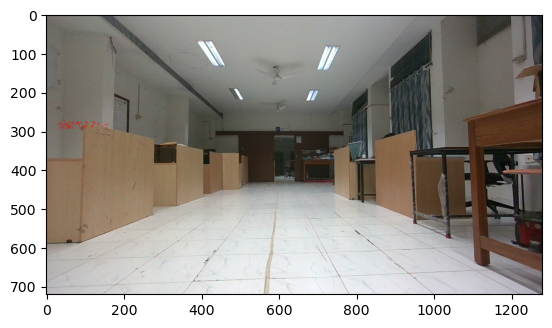

In [13]:
import matplotlib.pyplot as plt
rgb = cv2.cvtColor(cv2.imread(os.path.join(data_dir, "rgb", "img_0.png")), cv2.COLOR_BGR2RGB)

for i in w:
    # print(i)
    rgb = cv2.circle(rgb, (i[1], i[0]), radius = 2, color = (255, 0, 0), thickness = 1)
    

plt.imshow(rgb)
plt.show()

In [14]:
# Table, x,y - (131,353), (258,353), (124, 519), (251, 495)
print(w[:, 1])
print(w.shape)

[ 53 120  71 125  80  80 104  54  83  58  39 103 118 133  95  51 145  58
  64 153  67  43  48 107 124  36  97  36  67  60  90  42  59  85 157 134
 121  88 104  56  62  33  47  71  85 156]
(46, 2)


# Landmark Indexing

## Load packages

In [15]:
%matplotlib inline
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from utils.clip_mapping_utils import load_map, get_new_pallete, get_new_mask_pallete
from utils.clip_utils import get_text_feats
from utils.mp3dcat import mp3dcat
import clip

100%|██████████| 274/274 [10:09<00:00,  2.23s/it]


## Setup Load Paths

Set `use_self_built_map` to False to use the map we provided, and set it to True if you want to try the map you built in the `VLMap Creation` section.

In [16]:
use_self_built_map = True # @param {type: "boolean"} 
map_save_dir = os.path.join(data_dir, "map_correct")
if use_self_built_map:
    map_save_dir = os.path.join(data_dir, "map")
os.makedirs(map_save_dir, exist_ok=True)

color_top_down_save_path = os.path.join(map_save_dir, f"color_top_down_1.npy")
grid_save_path = os.path.join(map_save_dir, f"grid_lseg_1.npy")
obstacles_save_path = os.path.join(map_save_dir, "obstacles.npy")



## Show Obstacle Map

[0 1]


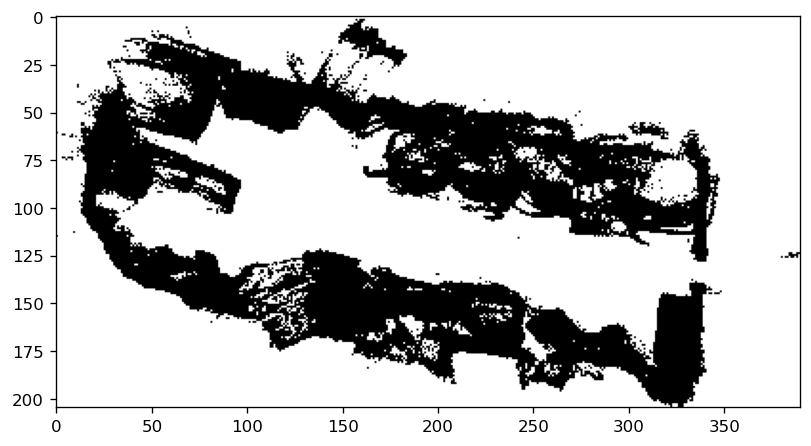

In [17]:
obstacles = load_map(obstacles_save_path)
x_indices, y_indices = np.where(obstacles == 0)

xmin = np.min(x_indices)
xmax = np.max(x_indices)
ymin = np.min(y_indices)
ymax = np.max(y_indices)

print(np.unique(obstacles))
obstacles_pil = Image.fromarray(obstacles[xmin:xmax+1, ymin:ymax+1])
plt.figure(figsize=(8, 6), dpi=120)
plt.imshow(obstacles_pil, cmap='gray')
plt.savefig(os.path.join(map_save_dir, "obstacles.png"))
plt.show()

you can see that the obstacles are black and the free space is white. You can also observe noisy black points lying on the ground. These points are caused by the slope or different floor heights in the scene.

## Show Top-Down Color Map

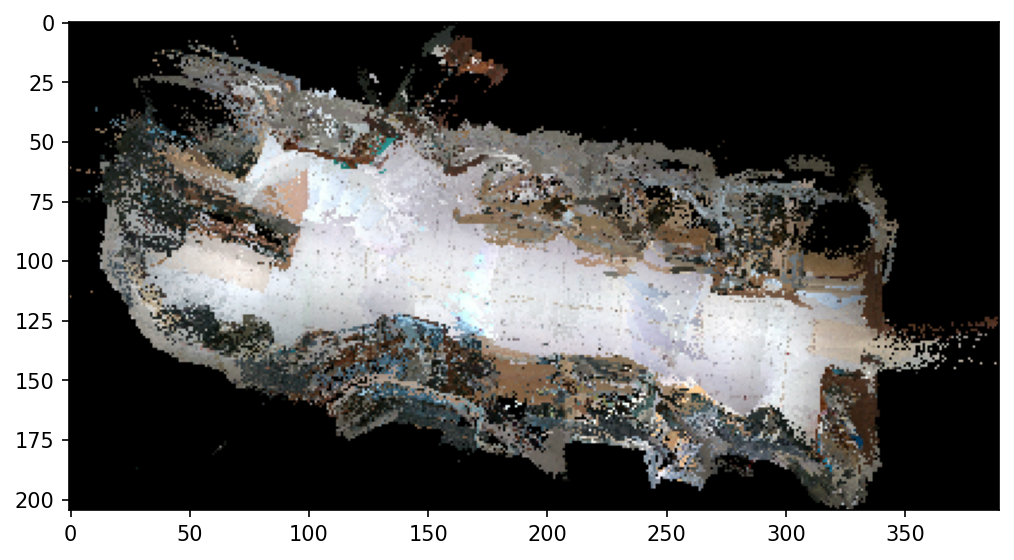

In [18]:
color_top_down = load_map(color_top_down_save_path)
color_top_down = color_top_down[xmin:xmax+1, ymin:ymax+1]
color_top_down_pil = Image.fromarray(color_top_down)
plt.figure(figsize=(8,6), dpi=150)
plt.imshow(color_top_down_pil)
plt.savefig(os.path.join(map_save_dir, "top_down_color.png"))
plt.show()


the color map is created by projecting the color-augmented point cloud to the floor.

## Show Landmark Indexing Results

In [19]:
%%capture
device = "cuda" if torch.cuda.is_available() else "cpu"
clip_version = "ViT-B/32"
clip_feat_dim = {'RN50': 1024, 'RN101': 512, 'RN50x4': 640, 'RN50x16': 768,
                'RN50x64': 1024, 'ViT-B/32': 512, 'ViT-B/16': 512, 'ViT-L/14': 768}[clip_version]
clip_model, preprocess = clip.load(clip_version)  # clip.available_models()
clip_model.to(device).eval()

In [20]:
grid = load_map(grid_save_path)
grid = grid[xmin:xmax+1, ymin:ymax+1]

we use the text form of all semantic categories provided by the Matterport3D dataset as prompts to the VLMap and localize all categories in the map. We filter out "floor" category.

(205, 390)


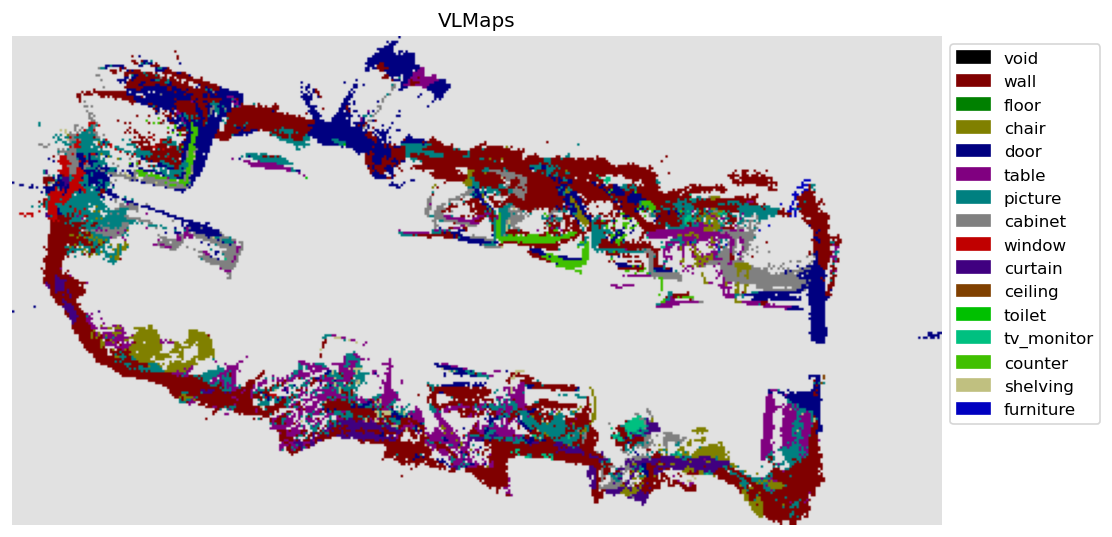

In [21]:
no_map_mask = obstacles[xmin:xmax+1, ymin:ymax+1] > 0
obstacles_rgb = np.repeat(obstacles[xmin:xmax+1, ymin:ymax+1, None], 3, axis=2)
print(no_map_mask.shape)

lang = mp3dcat 
text_feats = get_text_feats(lang, clip_model, clip_feat_dim)

map_feats = grid.reshape((-1, grid.shape[-1]))
scores_list = map_feats @ text_feats.T

predicts = np.argmax(scores_list, axis=1)
predicts = predicts.reshape((xmax - xmin + 1, ymax - ymin + 1))
floor_mask = predicts == 2

new_pallete = get_new_pallete(len(lang))
mask, patches = get_new_mask_pallete(predicts, new_pallete, out_label_flag=True, labels=lang)
seg = mask.convert("RGBA")
seg = np.array(seg)
seg[no_map_mask] = [225, 225, 225, 255]
seg[floor_mask] = [225, 225, 225, 255]
seg = Image.fromarray(seg)
plt.figure(figsize=(10, 6), dpi=120)
plt.legend(handles=patches, loc='upper left', bbox_to_anchor=(1., 1), prop={'size': 10})
plt.axis('off')
plt.title("VLMaps")
plt.imshow(seg)
plt.savefig(os.path.join(map_save_dir, "indexing1.png"))
plt.show()

## Open-Vocabulary Landmark Indexing

In addition to using the fixed set of categories, we can also use customized text prompts to the map and index their corresponding locations. You could play around with the `lang` variable below by providing your own prompt. 

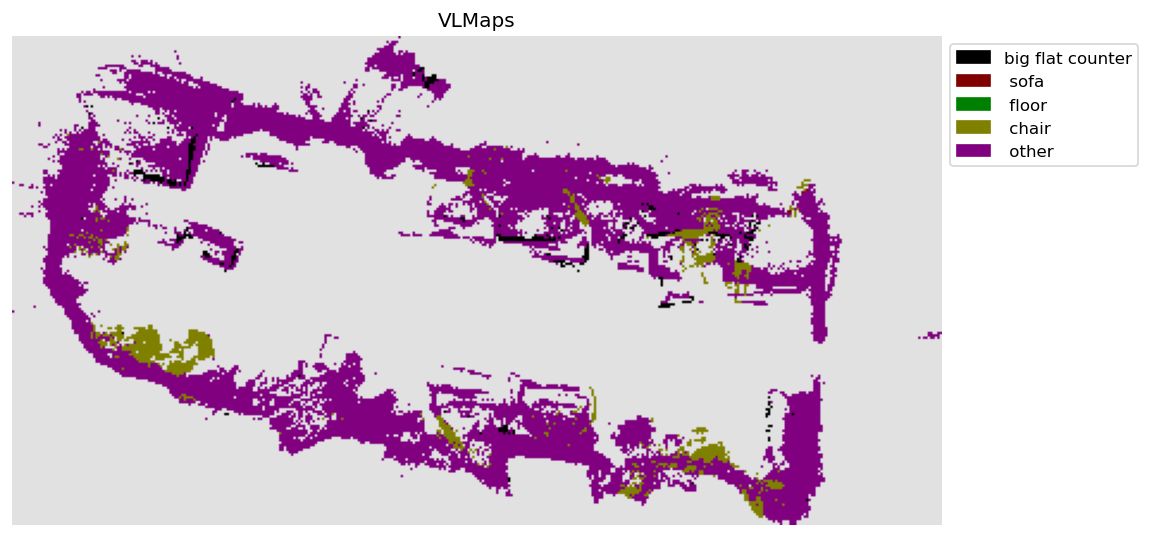

In [22]:
# @markdown Input the prompt as a string of object names separated by ","
lang = "big flat counter, sofa, floor, chair, wash basin, other" # @param {type: "string"}
lang = lang.split(",")
text_feats = get_text_feats(lang, clip_model, clip_feat_dim)

map_feats = grid.reshape((-1, grid.shape[-1]))
scores_list = map_feats @ text_feats.T

predicts = np.argmax(scores_list, axis=1)
predicts = predicts.reshape((xmax - xmin + 1, ymax - ymin + 1))
floor_mask = predicts == 2

new_pallete = get_new_pallete(len(lang))
mask, patches = get_new_mask_pallete(predicts, new_pallete, out_label_flag=True, labels=lang)
seg = mask.convert("RGBA")
seg = np.array(seg)
seg[no_map_mask] = [225, 225, 225, 255]
seg[floor_mask] = [225, 225, 225, 255]
seg = Image.fromarray(seg)
plt.figure(figsize=(10, 6), dpi=120)
plt.legend(handles=patches, loc='upper left', bbox_to_anchor=(1., 1), prop={'size': 10})
plt.axis('off')
plt.title("VLMaps")
plt.imshow(seg)
plt.savefig(os.path.join(map_save_dir, "indexing2.png"))
plt.show()

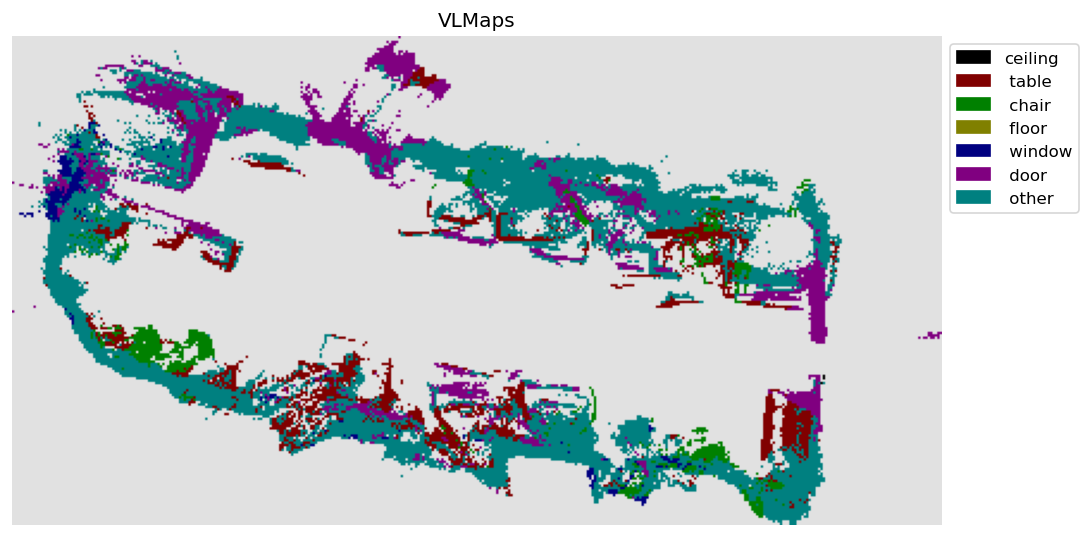

In [23]:
# @markdown Input the prompt as a string of object names separated by ","
lang = "ceiling, table, chair, floor, window, door, other" # @param {type: "string"}
lang = lang.split(",")
text_feats = get_text_feats(lang, clip_model, clip_feat_dim)

map_feats = grid.reshape((-1, grid.shape[-1]))
scores_list = map_feats @ text_feats.T

predicts = np.argmax(scores_list, axis=1)
predicts = predicts.reshape((xmax - xmin + 1, ymax - ymin + 1))
floor_mask = predicts == 3

new_pallete = get_new_pallete(len(lang))
mask, patches = get_new_mask_pallete(predicts, new_pallete, out_label_flag=True, labels=lang)
seg = mask.convert("RGBA")
seg = np.array(seg)
seg[no_map_mask] = [225, 225, 225, 255]
seg[floor_mask] = [225, 225, 225, 255]
seg = Image.fromarray(seg)
plt.figure(figsize=(10, 6), dpi=120)
plt.legend(handles=patches, loc='upper left', bbox_to_anchor=(1., 1), prop={'size': 10})
plt.axis('off')
plt.title("VLMaps")
plt.imshow(seg)
plt.savefig(os.path.join(map_save_dir, "indexing3.png"))
plt.show()

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 ...
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]


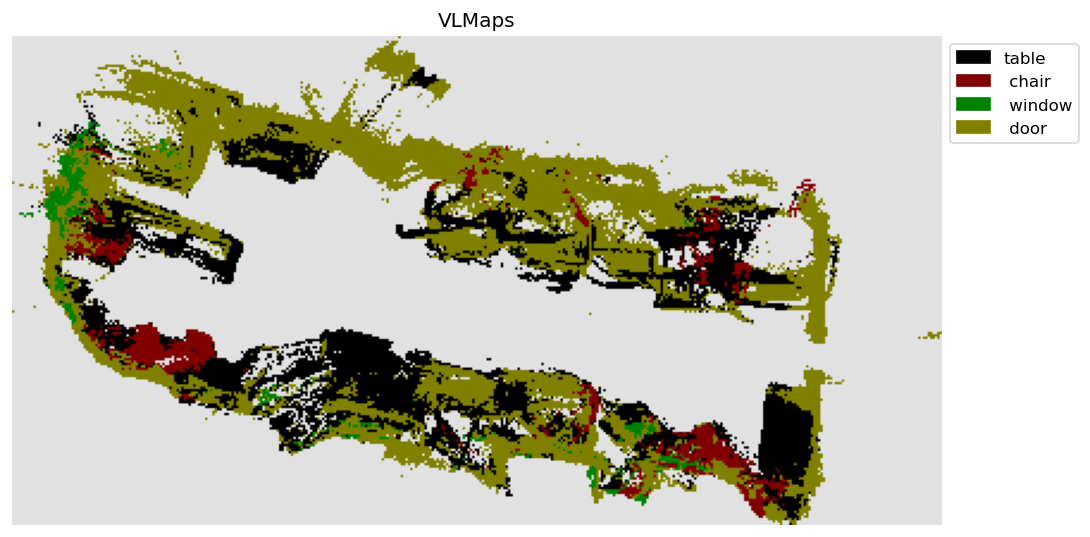

In [27]:
# @markdown Input the prompt as a string of object names separated by ","
lang = "table, chair, window, door" # @param {type: "string"}
lang = lang.split(",")
text_feats = get_text_feats(lang, clip_model, clip_feat_dim)

map_feats = grid.reshape((-1, grid.shape[-1]))
print(map_feats)
scores_list = map_feats @ text_feats.T
print(scores_list)

predicts = np.argmax(scores_list, axis=1)
predicts = predicts.reshape((xmax - xmin + 1, ymax - ymin + 1))
# floor_mask = predicts == 4

new_pallete = get_new_pallete(len(lang))
mask, patches = get_new_mask_pallete(predicts, new_pallete, out_label_flag=True, labels=lang)
seg = mask.convert("RGBA")
seg = np.array(seg)
seg[no_map_mask] = [225, 225, 225, 255]
# seg[floor_mask] = [225, 225, 225, 255]
seg = Image.fromarray(seg)
plt.figure(figsize=(10, 6), dpi=120)
plt.legend(handles=patches, loc='upper left', bbox_to_anchor=(1., 1), prop={'size': 10})
plt.axis('off')
plt.title("VLMaps")
plt.imshow(seg)
plt.savefig(os.path.join(map_save_dir, "indexing4.png"))
plt.show()

# Citation
If you find this code useful to you, please cite our paper. You can find more results on the website of our paper [here](https://vlmaps.github.io/).
```
@article{huang22vlmaps,
  title     = {Visual Language Maps for Robot Navigation},
  author    = {Chenguang Huang and Oier Mees and Andy Zeng and Wolfram Burgard},
  journal   = {arXiv preprint arXiv:2210.05714},
  year      = {2022},
}
```